In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from scipy.stats import kurtosis
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.random_projection import GaussianRandomProjection

#### spam data

In [2]:
spam_path = '../Project 1/spam/'

In [3]:
with open(os.path.join(spam_path, 'spambase.names')) as f:
    names = f.readlines()
cols = [c for c in names if c[0] != '|']
cols = [c.replace('\n', '') for c in cols]
cols = [c.split(':')[0] for c in cols]
cols = [c for c in cols if c]

In [4]:
df = pd.read_csv(os.path.join(spam_path, 'spambase.data'), header=None, names=cols)

In [5]:
X_cols = df.columns[:-1]
y_col = df.columns.difference(X_cols)[0]
X = df[X_cols]
y = df[y_col]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, train_size=.8, shuffle=True, random_state=42
)

In [7]:
ss = StandardScaler()
x_cols = X.columns
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

#### functions

In [8]:
def calc_confusion_vals(y, y_pred):
    tp = (y_pred[y == 1] == 1).sum()
    tn = (y_pred[y == 0] == 0).sum()
    fp = (y_pred[y == 0] == 1).sum()
    fn = (y_pred[y == 1] == 0).sum()
    return tp, tn, fp, fn

In [9]:
def calc_metric(tp, tn, fp, fn, name):
    if name == 'accuracy':
        metric = (tp + tn) / sum([tp, tn, fp, fn])
    elif name == 'recall':
        metric = tp / (tp + fn)
    elif name == 'precision':
        metric = tp / (tp + fp)
    elif name == 'specificity':
        metric = tn / (tn + fp)
    elif name == 'npv':
        metric = tn / (tn + fn)
    elif name == 'f1':
        metric = tp / (tp + (.5 * (fp + fn)))
    return metric

In [10]:
def get_best_val(results, metric):
    mean_results = results.groupby('val')[metric].mean()
    best_val = mean_results.idxmax()
    return best_val

In [11]:
def tune_params(model, X, y, params, metric):
    
    outcomes = ['tp', 'tn', 'fp', 'fn', metric]
    cols = ['order', 'param', 'val', 'trial', 'train_time', 'pred_train_time', 'pred_val_time']
    cols += [f'train_{o}' for o in outcomes]
    cols += [f'val_{o}' for o in outcomes]
    results = pd.DataFrame(columns=cols, dtype=int)
    best_params = {}
    if model.__name__ not in {'KNeighborsClassifier'}:
        best_params = {'random_state': 42}
    if model.__name__ == 'MLPClassifier':
        best_params['max_iter'] = 1000
    kfolds = StratifiedKFold(5, shuffle=True, random_state=42)
    i = -1
    for param, vals in params.items():
        i += 1
        param_results = {col: [] for col in cols}
        print(param)
        for val in vals:
            print(val)
            model_inst = model(**{param: val}, **best_params)
            for j, (train_idx, val_idx) in enumerate(kfolds.split(X, y)):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_val = X[val_idx]
                y_val = y[val_idx]
                param_results['order'].append(i)
                if model.__name__ == 'AdaBoostClassifier' and param == 'base_estimator':
                    param_results['param'].append('max_depth')
                    param_results['val'].append(val.max_depth)
                else:
                    param_results['param'].append(param)
                    param_results['val'].append(val)
                param_results['trial'].append(j)
                t1 = time.time()
                model_inst.fit(X_train, y_train)
                t2 = time.time()
                param_results['train_time'].append(t2 - t1)
                for X_inst, y_inst, pred_type in zip([X_train, X_val], [y_train, y_val], ['train', 'val']):
                    t1 = time.time()
                    y_pred = model_inst.predict(X_inst)
                    t2 = time.time()
                    param_results[f'pred_{pred_type}_time'].append(t2 - t1)
                    tp, tn, fp, fn = calc_confusion_vals(y_inst, y_pred)
                    param_results[f'{pred_type}_tp'].append(tp)
                    param_results[f'{pred_type}_tn'].append(tn)
                    param_results[f'{pred_type}_fp'].append(fp)
                    param_results[f'{pred_type}_fn'].append(fn)
        for pred_type in ['train', 'val']:
            param_results[f'{pred_type}_{metric}'] = np.nan
        param_results = pd.DataFrame(param_results)
        for pred_type in ['train', 'val']:
            param_results[f'{pred_type}_{metric}'] = calc_metric(
                param_results[f'{pred_type}_tp'],
                param_results[f'{pred_type}_tn'],
                param_results[f'{pred_type}_fp'],
                param_results[f'{pred_type}_fn'],
                metric
            )
        best_val = get_best_val(param_results, f'val_{metric}')
        if model.__name__ == 'AdaBoostClassifier' and param == 'base_estimator':
            best_params[param] = DecisionTreeClassifier(max_depth=best_val)
        else:
            best_params[param] = best_val
        results = pd.concat([results, param_results], axis=0)
    results.reset_index(drop=True, inplace=True)
    return results, best_params

In [12]:
def graph_param_tuning(results, metric, data_name):
    
    orders = results['order'].unique()
    fig, ax = plt.subplots(1, len(orders), figsize=(16, 5), sharey=True)
    fig.suptitle(f'{data_name} Parameter Tuning', fontsize=16)
    ax[0].set_ylabel(metric.capitalize())
    for i in sorted(orders):
        param_results = results.query('order == @i')
        param = param_results['param'].iloc[0]
        for j, (label, pred_type),  in enumerate(zip(['Train', 'Validation'], ['train', 'val'])):
            scores = calc_metric(
                param_results[f'{pred_type}_tp'],
                param_results[f'{pred_type}_tn'],
                param_results[f'{pred_type}_fp'],
                param_results[f'{pred_type}_fn'],
                metric
            )
            mean_scores = scores.groupby(param_results['val']).mean()
            if pd.api.types.is_numeric_dtype(mean_scores.index.dtype):
                ax[i].plot(mean_scores.index, mean_scores.values, marker='o', label=label)
            else:
                w = .35
                x = np.arange(len(mean_scores.index)) + ((j - .5) * w)
                ax[i].bar(x, mean_scores.values, width=w, label=label)
                ax[i].set_xticks(x - ((j - .5) * w))
                ax[i].set_xticklabels(mean_scores.index)
        param_name = param.replace('_', ' ').title()
        ax[i].set_title(f'{param_name} Tuning')
        if param == 'learning_rate_init':
            ax[i].set_xscale('log')
        ax[i].set_xlabel(param_name)
        ax[i].legend()
    plt.show()

In [13]:
def calc_performance_over_training_size(model, X, y, params):
    
    pcts = np.linspace(.2, 1, 5)
    outcomes = ['tp', 'tn', 'fp', 'fn']
    cols = ['trial', 'percent', 'train_time', 'pred_train_time', 'pred_val_time']
    cols += [f'train_{o}' for o in outcomes]
    cols += [f'val_{o}' for o in outcomes]
    results = pd.DataFrame(columns=cols, dtype=int)
    model_inst = model(**params)
    kfolds = StratifiedKFold(5, shuffle=True, random_state=42)
    for pct in pcts:
        if pct < 1:
            X_sub, _, y_sub, _ = train_test_split(X, y, stratify=y, train_size=pct, shuffle=True, random_state=42)
        elif pct == 1:
            X_sub = X.copy()
            y_sub = y.copy()
        param_results = {col: [] for col in cols}
        for i, (train_idx, val_idx) in enumerate(kfolds.split(X_sub, y_sub)):
            param_results['percent'].append(pct)
            X_train = X_sub[train_idx]
            y_train = y_sub[train_idx]
            X_val = X_sub[val_idx]
            y_val = y_sub[val_idx]
            param_results['trial'].append(i)
            t1 = time.time()
            model_inst.fit(X_train, y_train)
            t2 = time.time()
            param_results['train_time'].append(t2 - t1)
            for X_inst, y_inst, pred_type in zip([X_train, X_val], [y_train, y_val], ['train', 'val']):
                t1 = time.time()
                y_pred = model_inst.predict(X_inst)
                t2 = time.time()
                param_results[f'pred_{pred_type}_time'].append(t2 - t1)
                tp, tn, fp, fn = calc_confusion_vals(y_inst, y_pred)
                param_results[f'{pred_type}_tp'].append(tp)
                param_results[f'{pred_type}_tn'].append(tn)
                param_results[f'{pred_type}_fp'].append(fp)
                param_results[f'{pred_type}_fn'].append(fn)
        param_results = pd.DataFrame(param_results)
        results = pd.concat([results, param_results], axis=0)
    results.reset_index(drop=True, inplace=True)
    return results

In [14]:
def graph_performance_over_training_size(results, metrics, data_name):
    
    fig, ax = plt.subplots(1, len(metrics), figsize=(16, 5), sharey=True)
    fig.suptitle(f'{data_name} Learning Curve Over Training Size', fontsize=16)
    ax[0].set_ylabel('Score')
    for i, metric in enumerate(metrics):
        for label, pred_type in zip(['Train', 'Validation'], ['train', 'val']):
            scores = calc_metric(
                results[f'{pred_type}_tp'],
                results[f'{pred_type}_tn'],
                results[f'{pred_type}_fp'],
                results[f'{pred_type}_fn'],
                metric
            )
            mean_scores = scores.groupby(results['percent']).mean()
            ax[i].plot(mean_scores.index, mean_scores.values, marker='o', label=label)
        ax[i].set_title(metric.title())
        ax[i].set_xlabel('Training Size')
        ax[i].set_xticklabels([f'{int(p*100)}%' for p in ax[i].get_xticks()])
        ax[i].legend()
    plt.show()

In [15]:
def calc_learning_curve(model, X, y, params, svm_step=2000):
    
    iters = np.linspace(.2, 1, 5)
    outcomes = ['tp', 'tn', 'fp', 'fn']
    cols = ['iteration']
    cols += [f'train_{o}' for o in outcomes]
    cols += [f'val_{o}' for o in outcomes]
    results = pd.DataFrame(columns=cols, dtype=int)
    model_inst = model(**params)
    X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, train_size=.8, shuffle=True, random_state=42)
    
    if model.__name__ == 'AdaBoostClassifier':
        model_inst.fit(X_train, y_train)
        train_preds = model_inst.staged_predict(X_train)
        val_preds = model_inst.staged_predict(X_val)
    elif model.__name__ == 'MLPClassifier':
        classes = np.unique(y_train)
        train_preds = []
        val_preds = []
        for i in range(params['max_iter']):
            model_inst.partial_fit(X_train, y_train, classes)
            train_preds.append(model_inst.predict(X_train))
            val_preds.append(model_inst.predict(X_val))
    elif model.__name__ == 'SVC':
        train_preds = []
        val_preds = []
        for i in range(svm_step, svm_step*20 + 1, svm_step):
            model_inst.set_params(max_iter=i)
            model_inst.fit(X_train, y_train)
            train_preds.append(model_inst.predict(X_train))
            val_preds.append(model_inst.predict(X_val))
    
    for i, (y_train_pred, y_val_pred) in enumerate(zip(train_preds, val_preds), 1):
        iter_results = {}
        if model.__name__ == 'SVC':
            iter_results['iteration'] = [i * svm_step]
        else:
            iter_results['iteration'] = [i]
        for y_true, y_pred, pred_type in zip([y_train, y_val], [y_train_pred, y_val_pred], ['train', 'val']):
            tp, tn, fp, fn = calc_confusion_vals(y_true, y_pred)
            iter_results[f'{pred_type}_tp'] = [tp]
            iter_results[f'{pred_type}_tn'] = [tn]
            iter_results[f'{pred_type}_fp'] = [fp]
            iter_results[f'{pred_type}_fn'] = [fn]
        iter_results = pd.DataFrame(iter_results)
        results = pd.concat([results, iter_results], axis=0)
        
    results.reset_index(drop=True, inplace=True)
    return results

In [16]:
def graph_learning_curve(results, metrics, data_name):
    
    fig, ax = plt.subplots(1, len(metrics), figsize=(16, 5), sharey=True)
    fig.suptitle(f'{data_name} Learning Curve Over Training Iterations', fontsize=16)
    ax[0].set_ylabel('Score')
    for i, metric in enumerate(metrics):
        for label, pred_type in zip(['Train', 'Validation'], ['train', 'val']):
            scores = calc_metric(
                results[f'{pred_type}_tp'],
                results[f'{pred_type}_tn'],
                results[f'{pred_type}_fp'],
                results[f'{pred_type}_fn'],
                metric
            )
            ax[i].plot(results['iteration'], scores.values, marker='o', label=label)
        ax[i].set_title(metric.title())
        ax[i].set_xlabel('Iteration')
        ax[i].legend()
    plt.show()

#### prep

In [17]:
results = {
    'none': {},
    'pca': {},
    'ica': {},
    'rp': {},
    'rf': {}
}

In [18]:
pca = PCA(2, random_state=4200)
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)

ica = FastICA(5, random_state=4200)
X_ica_train = ica.fit_transform(X_train)
X_ica_test = ica.transform(X_test)

rp = GaussianRandomProjection(10, random_state=4200)
X_rp_train = rp.fit_transform(X_train)
X_rp_test = rp.transform(X_test)

# random forest
X_rf_train = X_train[:, [52, 51, 6]].copy()
X_rf_test = X_test[:, [52, 51, 6]].copy()

In [19]:
model = MLPClassifier
params = {
    'learning_rate_init': [.0001, .0005, .001, .005, .01, .05, .1],
    'hidden_layer_sizes': [10, 50, 100, 300],
    'activation': ['identity', 'logistic', 'relu']
}

#### no DR

In [20]:
tune_results, best_params = tune_params(model, X_train, y_train.values, params, 'accuracy')

learning_rate_init
0.0001
0.0005
0.001
0.005
0.01
0.05
0.1
hidden_layer_sizes
10
50
100
300
activation
identity
logistic
relu


In [21]:
best_params

{'random_state': 42,
 'max_iter': 1000,
 'learning_rate_init': 0.0001,
 'hidden_layer_sizes': 100,
 'activation': 'relu'}

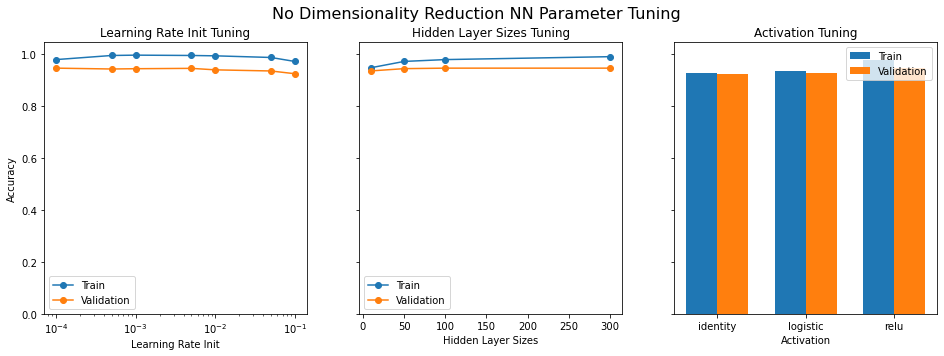

In [22]:
graph_param_tuning(tune_results, 'accuracy', 'No Dimensionality Reduction NN')

In [23]:
size_results = calc_performance_over_training_size(model, X_train, y_train.values, best_params)

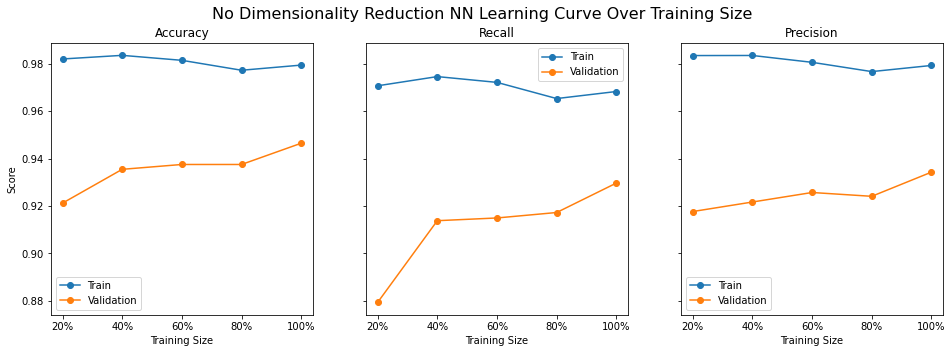

In [24]:
metrics = ['accuracy', 'recall', 'precision']
graph_performance_over_training_size(size_results, metrics, 'No Dimensionality Reduction NN')

In [25]:
learn_results = calc_learning_curve(model, X_train, y_train.values, best_params)

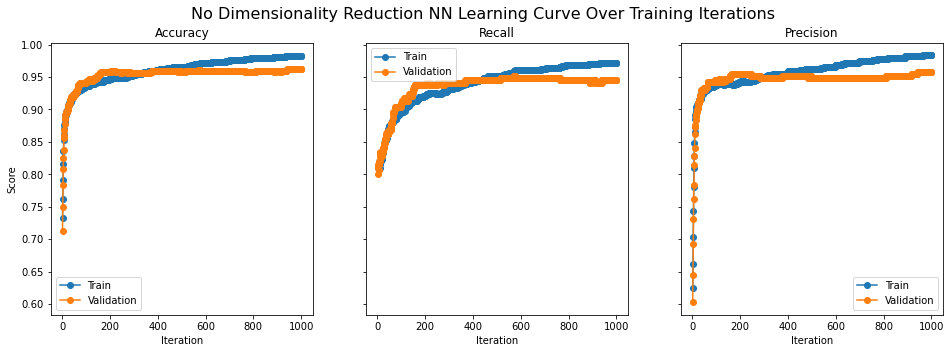

In [26]:
metrics = ['accuracy', 'recall', 'precision']
graph_learning_curve(learn_results, metrics, 'No Dimensionality Reduction NN')

In [27]:
results['none'] = {
    'best_params': best_params,
    'tune': tune_results,
    'size': size_results,
    'iter': learn_results
}

#### PCA

In [28]:
tune_results, best_params = tune_params(model, X_pca_train, y_train.values, params, 'accuracy')

learning_rate_init
0.0001
0.0005
0.001
0.005
0.01
0.05
0.1
hidden_layer_sizes
10
50
100
300
activation
identity
logistic
relu


In [29]:
best_params

{'random_state': 42,
 'max_iter': 1000,
 'learning_rate_init': 0.01,
 'hidden_layer_sizes': 100,
 'activation': 'relu'}

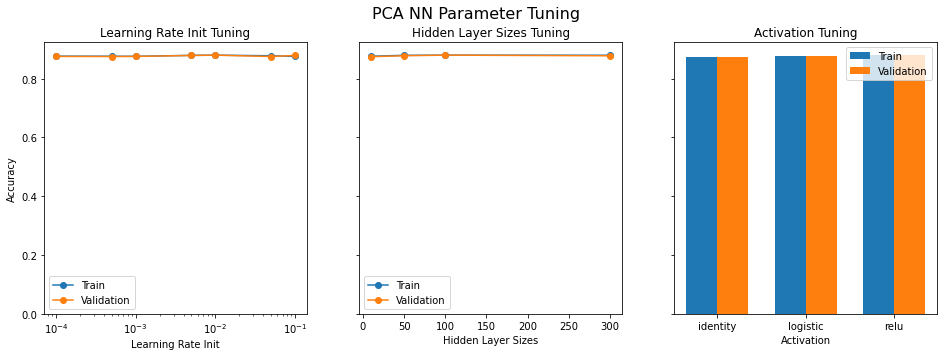

In [30]:
graph_param_tuning(tune_results, 'accuracy', 'PCA NN')

In [31]:
size_results = calc_performance_over_training_size(model, X_pca_train, y_train.values, best_params)

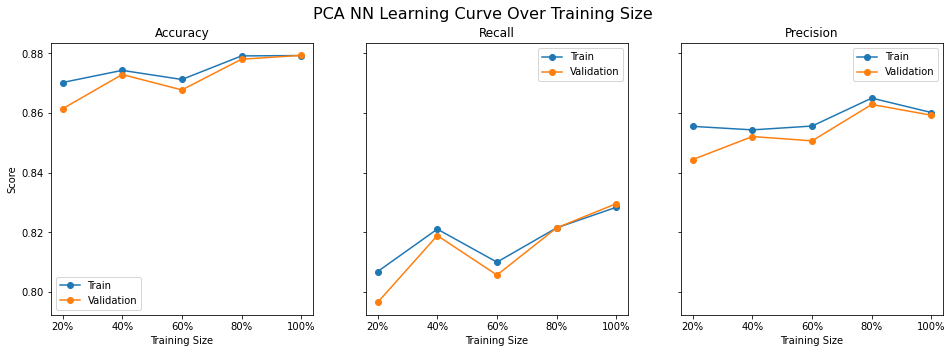

In [32]:
metrics = ['accuracy', 'recall', 'precision']
graph_performance_over_training_size(size_results, metrics, 'PCA NN')

In [33]:
learn_results = calc_learning_curve(model, X_pca_train, y_train.values, best_params)

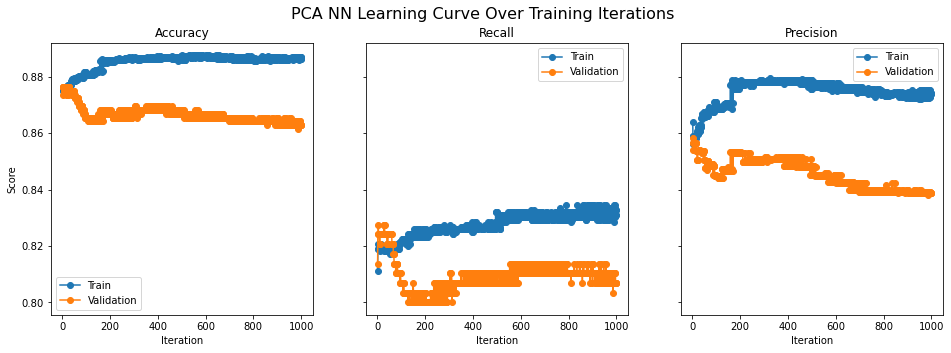

In [34]:
metrics = ['accuracy', 'recall', 'precision']
graph_learning_curve(learn_results, metrics, 'PCA NN')

In [35]:
results['pca'] = {
    'best_params': best_params,
    'tune': tune_results,
    'size': size_results,
    'iter': learn_results
}

#### ICA

In [36]:
tune_results, best_params = tune_params(model, X_ica_train, y_train.values, params, 'accuracy')

learning_rate_init
0.0001


/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-pack

0.0005


/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.001
0.005
0.01
0.05
0.1
hidden_layer_sizes
10
50
100
300
activation
identity
logistic
relu


In [37]:
best_params

{'random_state': 42,
 'max_iter': 1000,
 'learning_rate_init': 0.01,
 'hidden_layer_sizes': 100,
 'activation': 'relu'}

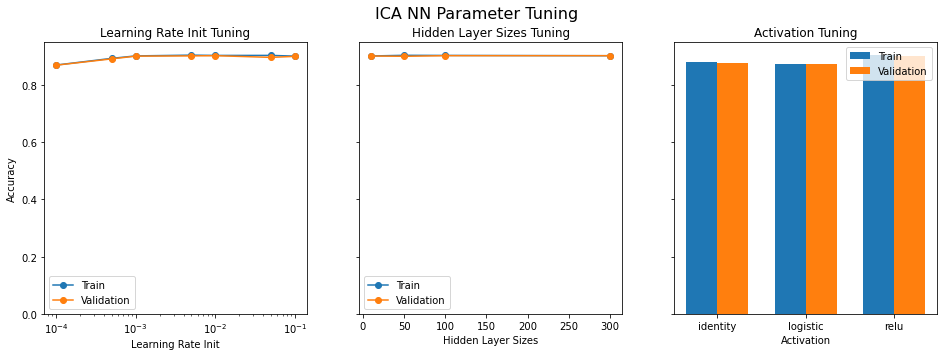

In [38]:
graph_param_tuning(tune_results, 'accuracy', 'ICA NN')

In [39]:
size_results = calc_performance_over_training_size(model, X_ica_train, y_train.values, best_params)

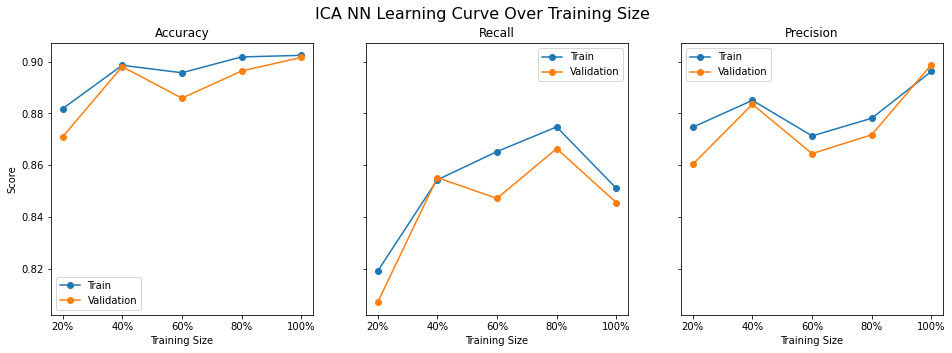

In [40]:
metrics = ['accuracy', 'recall', 'precision']
graph_performance_over_training_size(size_results, metrics, 'ICA NN')

In [41]:
learn_results = calc_learning_curve(model, X_ica_train, y_train.values, best_params)

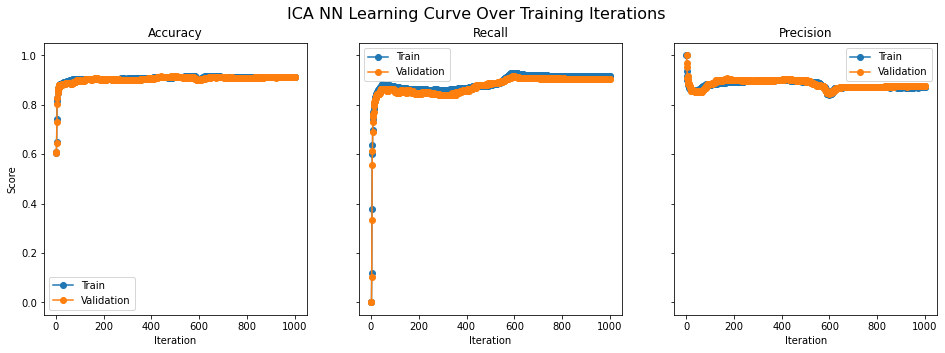

In [42]:
metrics = ['accuracy', 'recall', 'precision']
graph_learning_curve(learn_results, metrics, 'ICA NN')

In [43]:
results['ica'] = {
    'best_params': best_params,
    'tune': tune_results,
    'size': size_results,
    'iter': learn_results
}

#### Random Projections

In [44]:
tune_results, best_params = tune_params(model, X_rp_train, y_train.values, params, 'accuracy')

learning_rate_init
0.0001
0.0005


/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-pack

0.001


/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.005
0.01
0.05
0.1
hidden_layer_sizes
10
50


/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


100


/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-pack

300


/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


activation
identity
logistic


/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-pack

relu


/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [45]:
best_params

{'random_state': 42,
 'max_iter': 1000,
 'learning_rate_init': 0.0005,
 'hidden_layer_sizes': 300,
 'activation': 'relu'}

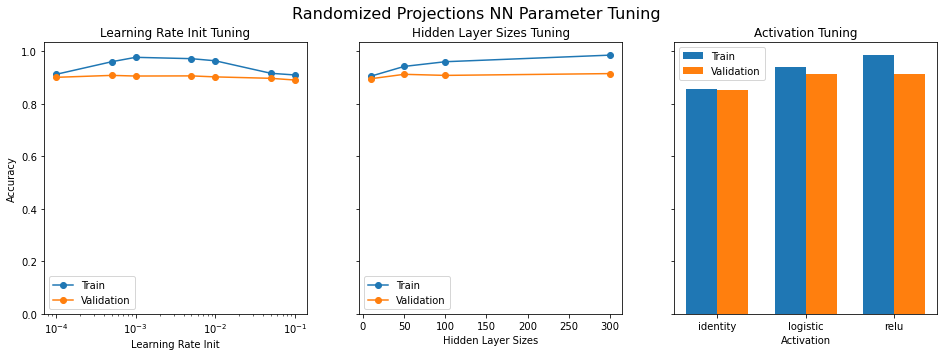

In [46]:
graph_param_tuning(tune_results, 'accuracy', 'Randomized Projections NN')

In [47]:
size_results = calc_performance_over_training_size(model, X_rp_train, y_train.values, best_params)

/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dan/anaconda3/lib/python3.8/site-pack

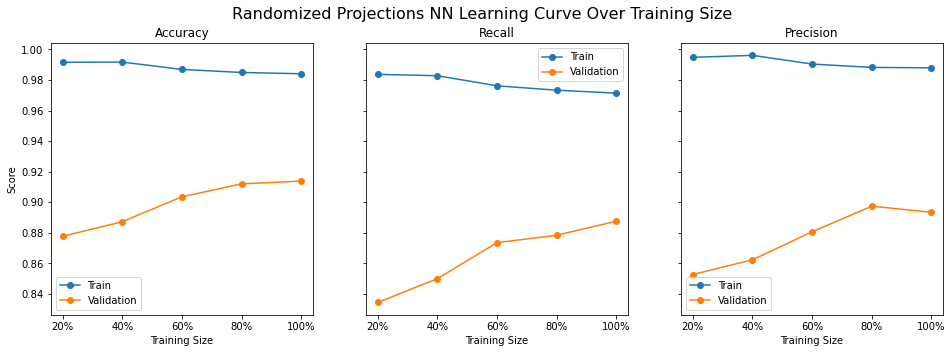

In [48]:
metrics = ['accuracy', 'recall', 'precision']
graph_performance_over_training_size(size_results, metrics, 'Randomized Projections NN')

In [49]:
learn_results = calc_learning_curve(model, X_rp_train, y_train.values, best_params)

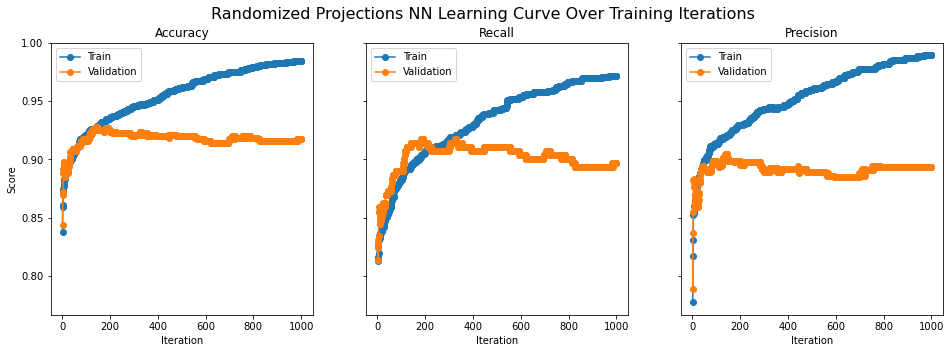

In [50]:
metrics = ['accuracy', 'recall', 'precision']
graph_learning_curve(learn_results, metrics, 'Randomized Projections NN')

In [51]:
results['rp'] = {
    'best_params': best_params,
    'tune': tune_results,
    'size': size_results,
    'iter': learn_results
}

#### Random Forest

In [52]:
tune_results, best_params = tune_params(model, X_rf_train, y_train.values, params, 'accuracy')

learning_rate_init
0.0001
0.0005
0.001
0.005
0.01
0.05
0.1
hidden_layer_sizes
10
50
100
300
activation
identity
logistic
relu


In [53]:
best_params

{'random_state': 42,
 'max_iter': 1000,
 'learning_rate_init': 0.01,
 'hidden_layer_sizes': 50,
 'activation': 'relu'}

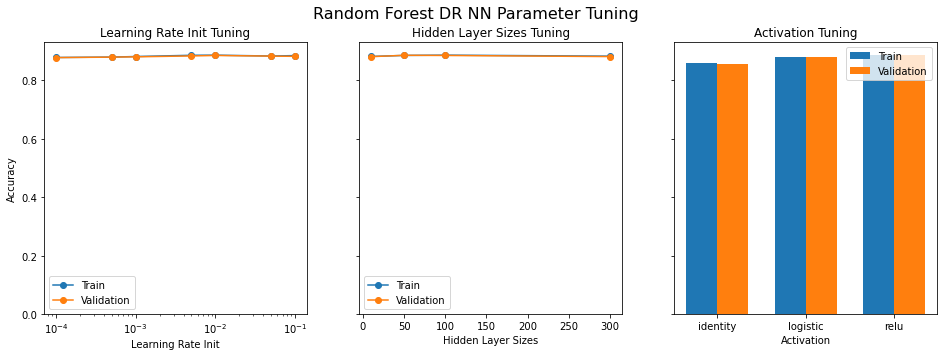

In [54]:
graph_param_tuning(tune_results, 'accuracy', 'Random Forest DR NN')

In [55]:
size_results = calc_performance_over_training_size(model, X_rf_train, y_train.values, best_params)

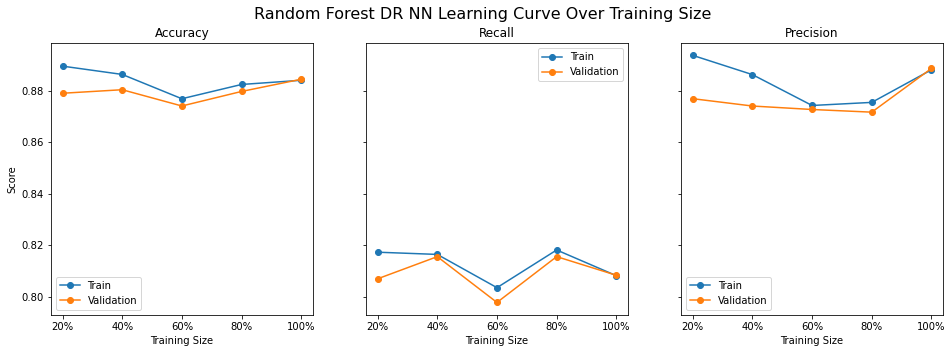

In [56]:
metrics = ['accuracy', 'recall', 'precision']
graph_performance_over_training_size(size_results, metrics, 'Random Forest DR NN')

In [57]:
learn_results = calc_learning_curve(model, X_rf_train, y_train.values, best_params)

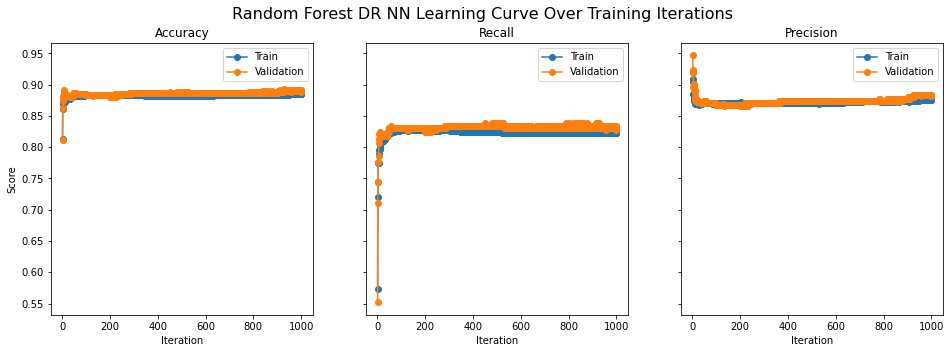

In [58]:
metrics = ['accuracy', 'recall', 'precision']
graph_learning_curve(learn_results, metrics, 'Random Forest DR NN')

In [59]:
results['rf'] = {
    'best_params': best_params,
    'tune': tune_results,
    'size': size_results,
    'iter': learn_results
}

#### final results

In [60]:
X_dict = {
    'none': (X_train, X_test),
    'pca': (X_pca_train, X_pca_test),
    'ica': (X_ica_train, X_ica_test),
    'rp': (X_rp_train, X_rp_test),
    'rf': (X_rf_train, X_rf_test),
}
results_cols = ['technique', 'train_time', 'accuracy', 'recall', 'precision']
final_results = pd.DataFrame(index=range(len(X_dict)), columns=results_cols)

for i, (name, (X_inst_train, X_inst_test)) in enumerate(X_dict.items()):
    
    final_results.loc[i, 'technique'] = name
    params_inst = results[name]['best_params']
    model_inst = model(**params_inst)
    t1 = time.time()
    model_inst.fit(X_inst_train, y_train)
    t2 = time.time()
    final_results.loc[i, 'train_time'] = t2 - t1
    y_pred = model_inst.predict(X_inst_test)
    tp, tn, fp, fn = calc_confusion_vals(y_test, y_pred)
    for metric_name in ['accuracy', 'recall', 'precision']:
        metric = calc_metric(tp, tn, fp, fn, metric_name)
        final_results.loc[i, metric_name] = metric

#### saving

In [61]:
for technique_name, model_results in results.items():
    path = f'./results/{technique_name}_nn'
    for results_name, data in model_results.items():
        full_path = f'{path}_{results_name}.csv'
        if isinstance(data, pd.DataFrame):
            data.to_csv(full_path)
        elif isinstance(data, dict):
            pd.DataFrame(data, index=[0]).to_csv(full_path)

In [62]:
path = f'./results/final_nn_dr_testing.csv'
final_results.to_csv(path)